In [14]:
# table of contents

# 1. PCA on digits for visualization
# 2. PCA on digits for compression
# 3. PCA on digits improve classification
# 4. K-means clustering on digits
# 5. Blind-source separation on sounds

import numpy as np
import pylab as py

%matplotlib inline

In [9]:
# digit recognition setup...

from sklearn.datasets import load_digits
digits = load_digits()

X, y = digits.data, digits.target
print("data shape: %r, target shape: %r" % (X.shape, y.shape))
print("classes: %r" % list(np.unique(y)))

n_samples, n_features = X.shape
print("n_samples=%d" % n_samples)
print("n_features=%d" % n_features)


data shape: (1797, 64), target shape: (1797,)
classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_samples=1797
n_features=64


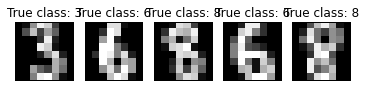

In [10]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        py.subplot(1, data.shape[0], (i + 1))
        py.imshow(data[i].reshape(shape), interpolation=interpolation)
        py.title(labels[i])
        py.xticks(()), py.yticks(())
        py.gray()

subsample = np.random.permutation(X.shape[0])[:5]
images = X[subsample]
labels = ['True class: %d' % l for l in y[subsample]]
plot_gallery(images, labels, shape=(8, 8))

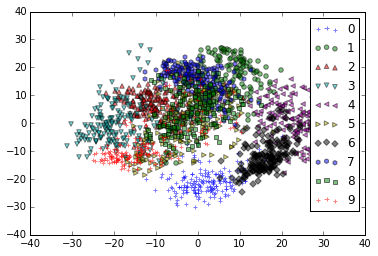

In [11]:
# 1. PCA on digits for visualization

from sklearn.decomposition import RandomizedPCA

pca = RandomizedPCA(n_components=5)
X_pca = pca.fit_transform(X)

X_pca.shape

from itertools import cycle

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
markers = ['+', 'o', '^', 'v', '<', '>', 'D', 'h', 's']
for i, c, m in zip(np.unique(y), cycle(colors), cycle(markers)):
    py.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
        c=c, marker=m, label=i, alpha=0.5)

_ = py.legend(loc='best')

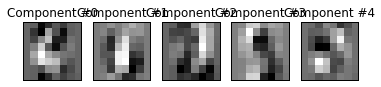

In [12]:
labels = ['Component #%d' % i for i in range(len(pca.components_))]
plot_gallery(pca.components_, labels, shape=(8, 8))

compressed images of first 8 digits
with this many PCA components: [1, 2, 3, 5, 10, 20, 40, 64]


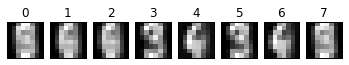

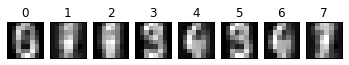

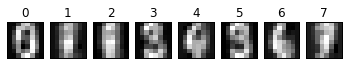

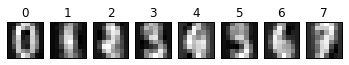

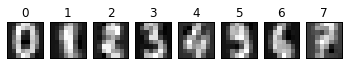

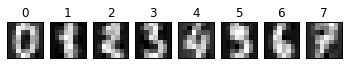

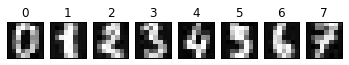

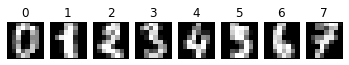

In [13]:
# 2. PCA on digits for compression

n = 8 # number of digits for demonstration
dims = [1,2,3,5,10,20,40,64]
print('compressed images of first',n,'digits')
print('with this many PCA components:',dims)
for d in dims:  # dimensionality for compressed signal
    pca = RandomizedPCA(n_components=d)
    pca.fit_transform(X)
    reduced_X = pca.transform(X[0:n]) # the reduced dimensionality
    recovered_X = pca.inverse_transform(reduced_X)
    py.figure()
    plot_gallery(recovered_X, y[0:n], shape=(8, 8))

In [7]:
# 3. PCA on digits improve classification

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

print("train data shape: %r, train target shape: %r"
      % (X_train.shape, y_train.shape))
print("test data shape: %r, test target shape: %r"
      % (X_test.shape, y_test.shape))

from sklearn.naive_bayes import GaussianNB
model = GaussianNB().fit(X_train, y_train)
train_score = model.score(X_train, y_train) 
print('training score (overfitting!):',train_score)

test_score = model.score(X_test, y_test)
print('test score:',test_score)

train data shape: (898, 64), train target shape: (898,)
test data shape: (899, 64), test target shape: (899,)
training score (overfitting!): 0.850779510022
test score: 0.810901001112


In [8]:
# but now using PCA features instead of pixels directly!

pca = RandomizedPCA(n_components=10)
pca.fit(X_train)

tX_train = pca.transform(X_train)
tX_test = pca.transform(X_test)

model = GaussianNB().fit(tX_train, y_train)
train_score = model.score(tX_train, y_train) 
print('training score (overfitting!):',train_score)

test_score = model.score(tX_test, y_test)
print('test score:',test_score)

from sklearn import metrics
y_test_pred = model.predict(tX_test)
expected = y_test
predicted = model.predict(tX_test)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

training score (overfitting!): 0.916481069042
test score: 0.915461624027
Confusion matrix:
[[89  0  0  0  0  0  0  0  0  0]
 [ 0 85  2  0  0  0  0  0  2  1]
 [ 0  7 83  1  0  0  0  1  0  0]
 [ 0  0  2 79  0  4  0  2  2  4]
 [ 0  1  0  0 71  0  0  4  0  0]
 [ 0  0  0  0  1 98  0  0  0  9]
 [ 0  2  0  0  0  0 84  0  2  1]
 [ 0  1  0  0  0  0  0 77  0  0]
 [ 0 13  0  1  0  1  0  1 72  4]
 [ 0  1  0  1  0  3  0  2  0 85]]


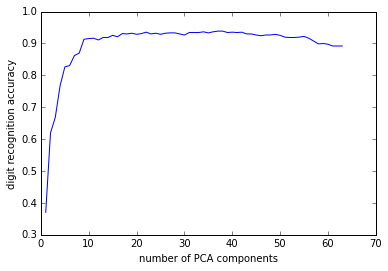

In [9]:
# let's plot accuracy vs number of components!

accuracy = []
n_comp = range(1,64)
for i in n_comp:
    pca = RandomizedPCA(n_components=i)
    pca.fit(X_train)

    tX_train = pca.transform(X_train)
    tX_test = pca.transform(X_test)

    model = GaussianNB().fit(tX_train, y_train)
    test_score = model.score(tX_test, y_test)
    accuracy.append(test_score)

py.plot(n_comp, accuracy)
py.xlabel('number of PCA components')
py.ylabel('digit recognition accuracy')

In [10]:
# 4. K-means clustering on digits

# identify 10 clusters (which should correspond to digits)
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=10)
k_means.fit(digits.data) 

print('true  :',digits.target[::50])
print('kmeans:',k_means.labels_[::50])

metrics.adjusted_rand_score(digits.target, k_means.labels_)

true  : [0 2 4 0 1 4 7 7 4 4 8 6 2 4 2 6 4 5 4 3 1 1 9 8 7 1 3 3 2 5 1 5 2 5 5 3]
kmeans: [0 1 7 0 6 7 2 2 7 7 8 5 4 7 1 5 7 9 7 3 4 1 9 3 2 1 3 3 8 8 6 9 4 9 9 3]


0.6715516390146404

In [11]:
dbscan = cluster.DBSCAN(eps = 24, min_samples = 20)
dbscan.fit(digits.data) 

print('true  :',digits.target[::50])
print('dbscan:',dbscan.labels_[::50])

metrics.adjusted_rand_score(digits.target, dbscan.labels_)

true  : [0 2 4 0 1 4 7 7 4 4 8 6 2 4 2 6 4 5 4 3 1 1 9 8 7 1 3 3 2 5 1 5 2 5 5 3]
dbscan: [ 0 -1  4  0  3  4  5  5  4  4 -1  2  8  4 -1  2  4  7  4  1 -1  6 -1 -1  5
  6  1  1 -1  7 -1  7  8  7  7  1]


0.5100021253245306

In [12]:
# 5. Blind-source separation on sounds

# read in sounds
from sklearn.decomposition import FastICA
import scipy.io.wavfile as wave

(rate, bach_data) = wave.read('bach.wav')
(rate, speech_data) = wave.read('speech.wav')

In [13]:
# mix the sounds with the following ratios: 2/1 and 2/3
print('original_X sound dimensions:',original_X.shape)
mixed_X = np.zeros(original_X.shape)

# mixes that shouldn't have to be normalized
mixed_X[:,0] = 2 * bach_data + 2 * speech_data
mixed_X[:,1] = 1 * bach_data + 3 * speech_data

# debugging info
#print(bach_data.dtype)   # int16
#print(mixed_X.dtype)     # should be int16

# save the mixes
wave.write('mix1.wav',rate, np.asarray(mixed_X[:,0],dtype=np.int16))
wave.write('mix2.wav',rate, np.asarray(mixed_X[:,1],dtype=np.int16))

NameError: name 'original_X' is not defined

In [110]:
# now to unmix! (note, this algorithm knowns NOTHING about the 
# structure of the signal or the amount they were mixed)
ica = FastICA(n_components=2)
unmixed_X = ica.fit_transform(mixed_X)  # Reconstruct signals
calculated_A = ica.mixing_  # Get estimated mixing matrix

In [111]:
# and show and save the results
print('unnormalized mixing matrix:\n',calculated_A)

# renormalize the mixing matrix to be compared with mixing ratios
normed_A = np.zeros((2,2))
normed_A[:,0] = calculated_A[:,0] / calculated_A[0,0] * 2
normed_A[:,1] = calculated_A[:,1] / calculated_A[0,1] * 2
print('normalized mixing matrix\n',normed_A)

wave.write('unmix1.wav',rate, np.asarray(unmixed_X[:,0] / np.max(unmixed_X[:,0]) * 14000,dtype=np.int16) )
wave.write('unmix2.wav',rate, np.asarray(unmixed_X[:,1] / np.max(unmixed_X[:,1]) * 14000,dtype=np.int16))

unnormalized mixing matrix:
 [[-1429538.24541078  2734566.094792  ]
 [-2297078.39806269  1298188.27475795]]
normalized mixing matrix
 [[ 2.          2.        ]
 [ 3.21373479  0.94946564]]
